# Compare regional APO contributions

Compare the background-subtracted observations with the modelled regional contribtuion of APO

We do this to investigate the effects of our modelled baseline on the correlations between the model and obs

In [1]:
import os, glob
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

from acrg import obs

import apo_funcs, apo_emiss_func, apo_plot_info

/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [23]:
year = 2015
months = [8, 12] # [i for i in range(1, 13)] #[1, 2, 3, 4, 5, 6] #[7, 8, 9, 10, 11, 12] #, 
sites = ['WAO']#, 'HFD']

# save the APO model and components
save_outputs = False

nrows = len(months) * len(sites)

# define the start and end dates from the year and months given above
starts = {month: datetime(year, month, 1) for month in months}
ends = {month: start + relativedelta(months=1, seconds=-1) for month, start in starts.items()}
# a date string to add the the filename for figures
date_str = f'{year}' if months==[mm for mm in range(1, 13)] else \
           f'{year}01-06' if months== [mm for mm in range(1, 7)] else \
           f'{year}07-12' if months== [mm for mm in range(7, 13)] else None

## Model the APO regional contribution

### Import the components

First we import the timeseries for each component, in per meg

In [3]:
ts_data_all = apo_funcs.get_timeseries(sites = sites,
                                       year = year,
                                       sources = ['bc', 'ff', 'ocean'])

Finding timeseries for WAO
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2015.nc']
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2015.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2015.nc']


/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
libLerc.so.4: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)



Dropping variables: 
['delta_o2_n2_bc', 'co2_ocean_ecco_mth', 'o2_ocean_ecco_mth', 'co2_ocean_nemo_mth', 'o2_ocean_nemo_mth']

Data variables: 
['co2_ff', 'apo_bc', 'co2_bc', 'o2_bc', 'apo_adjusted_bc', 'o2_ff', 'co2_ocean_ecco', 'o2_ocean_ecco', 'co2_ocean_jena', 'o2_ocean_jena', 'co2_ocean_nemo', 'o2_ocean_nemo', 'n2_ocean_nemo']
---------------------------



### Model APO

Combine the components into the APO model

We do this for each ocean estimate, and one version without the ocean

In [24]:
apo_model_year = {site_name: {ocean_sim: apo_emiss_func.apo(ocean_o2 = ts_site[f'o2_ocean_{ocean_sim}'],
                                                            ocean_co2 = ts_site[f'co2_ocean_{ocean_sim}'],
                                                            ocean_n2 = ts_site.n2_ocean_nemo,
                                                            ff_co2 = ts_site.co2_ff,
                                                            ff_o2 = ts_site.o2_ff)
                              for ocean_sim in ['ecco', 'jena', 'nemo']}
                  for site_name, ts_site in ts_data_all.items()}

apo_model_no_ocean = {site: apo_emiss_func.apo(ocean_co2 = xr.zeros_like(ts_site.o2_ocean_nemo),
                                                       ocean_n2 = xr.zeros_like(ts_site.o2_ocean_nemo),
                                                       ocean_o2 = xr.zeros_like(ts_site.o2_ocean_nemo),
                                                       ff_co2 = ts_site.co2_ff,
                                                       ff_o2 = ts_site.o2_ff)
                      for site, ts_site in ts_data_all.items()}

apo_model_year = {site: {sim: apo_model_no_ocean[site] if sim=='no ocean' else apo_site[sim]
                         for sim in list(apo_site.keys())+['no ocean']}
                 for site, apo_site in apo_model_year.items()}

apo_model = {site: {month: {ocean_sim: apo_sim.sel(time=slice(start, ends[month]))
                            for ocean_sim, apo_sim in apo_site.items()}
                    for month, start in starts.items()}
             for site, apo_site in apo_model_year.items()}

## Get the observations

Import the observational data

In [25]:
apo_obs = {month: obs.get_obs(
                            sites=sites,
                            species='APO',
                            start_date=start,
                            end_date=ends[month]
                            )
           for month, start in starts.items()}

apo_obs_year = obs.get_obs(
                        sites=sites,
                        species='APO',
                        start_date=f'{year}-01-01',
                        end_date=f'{year+1}-01-01'
                        ) 

Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20221215.nc
... slicing from 2015-08-01 00:00:00 to 2015-08-31 23:59:58.999999999
Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20221215.nc
... slicing from 2015-12-01 00:00:00 to 2015-12-31 23:59:58.999999999
Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20221215.nc
... slicing from 2015-01-01 00:00:00 to 2015-12-31 23:59:59.999999999


### Get the obs baseline

Import the baseline that UEA fit to the obs

In [6]:
obs_baseline_file = glob.glob(os.path.join('/user', 'work', 'vf20487', 'Data', f'WAO*{year}*baseline*txt'))[0]
print(f'Obs baseline file: {obs_baseline_file}')

# read in the data
obs_baseline_yr = pd.read_csv(obs_baseline_file, delimiter='\t')
# convert the dates to datetimes
obs_baseline_yr['time'] = pd.to_datetime(obs_baseline_yr['date'], format='%d/%m/%Y %H:%M')
# split into the separate months
# obs_baseline = {month: obs_baseline_yr.loc[(obs_baseline_yr['date']>=pd.to_datetime(start)) & (obs_baseline_yr['date']<pd.to_datetime(ends[month]))]
#                 for month, start in starts.items()}
# # set the date as the index
# obs_baseline = {month: obs_baseline_month.set_index('date')
#                 for month, obs_baseline_month in obs_baseline.items()}

obs_baseline_yr = obs_baseline_yr.set_index('time').to_xarray()
obs_baseline_yr = obs_baseline_yr['Stiff baseline - small gaps interpolated']

Obs baseline file: /user/work/vf20487/Data/WAO_2015_baseline.txt


### Subtract the baseline

In [26]:
apo_obs_bkg_sub_yr = {site: apo_site[0].mf - obs_baseline_yr for site, apo_site in apo_obs_year.items()}
apo_obs_bkg_sub = {month: {site: apo_site.sel(time=slice(start, ends[month]))
                           for site, apo_site in apo_obs_bkg_sub_yr.items()}
                   for month, start in starts.items()}

## Plot the model and obs

In [27]:
add_xlabel = True #False #
legend_outside = True #False #
supplement = False #True #

Saving to /user/work/vf20487/Figures/APO_timeseries/DeltaAPO-REBSbaseline_timeseries_WAO_2015.png


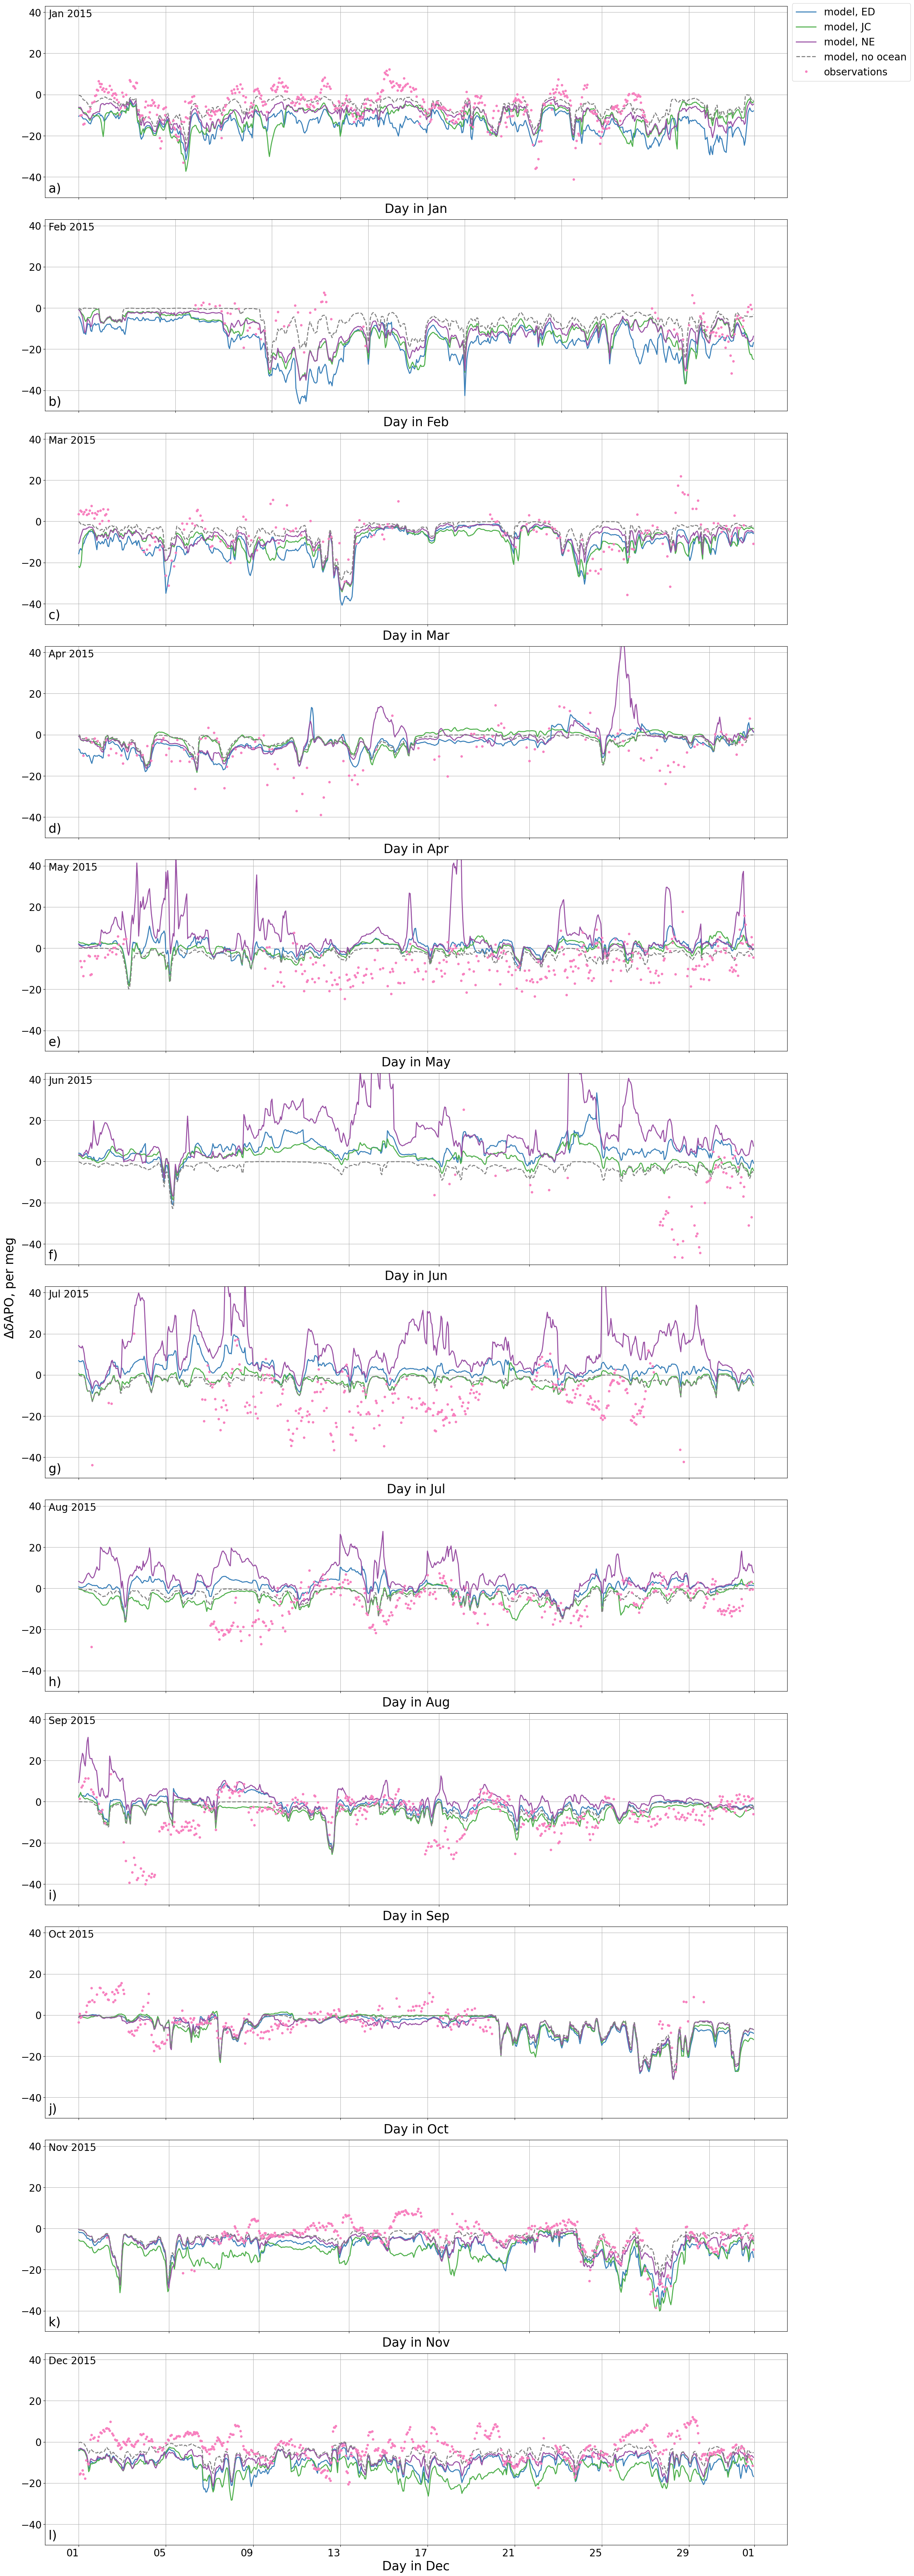

In [10]:
row_size = 3 if len(months) in [3, 4, 6] else 6 if any([len(var)>1 for var in [months, sites]]) else 6 if len(months)==2 else 8
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(25, row_size*nrows), constrained_layout=True)
axes = axes if type(axes)==np.ndarray else [axes]

ls = {sim: '--' if sim=='no ocean' else '-' for sim in apo_model[list(sites)[0]][months[0]]}
model_plots = {site: {month: {sim: apo_sim.plot(ax=axes[ss+mm*len(sites)], color=apo_plot_info.colors[sim.lower()], lw=2,
                                                ls=ls[sim], label=f'model, {apo_plot_info.model_names[sim.lower()]}')
                              for sim, apo_sim in apo_month.items()}
                      for mm, (month, apo_month) in enumerate(apo_site.items())}
               for ss, (site, apo_site) in enumerate(apo_model.items())}
obs_plots = {month: {site: apo_site.plot(ax=axes[ss+mm*len(sites)], color='#f781bf', label='observations', marker='o', ls='none', markersize=4)
                           if len(apo_site)>0 else None
                     for ss, (site, apo_site) in enumerate(apo_month.items())}
             for mm, (month, apo_month) in enumerate(apo_obs_bkg_sub.items())}

if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii!=len(sites)*len(months)-1]
       text = [axes[mm*len(sites)].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm*len(sites)].transAxes, va='top', fontsize=20)
               for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

if nrows>1:
       letter_start = len(months)*len(sites)*(months[0]-1)/2 if supplement else 0
       letters = [chr(97 + int(letter_start+ll)) if letter_start+ll<26 else
                  chr(97 + int(letter_start+ll-26))*2
                  for ll in range(len(months)*len(sites))]
       [axes[ii].xaxis.set_ticklabels([]) for ii in [i for i in range(0, len(axes)) if (i+1)%len(sites)!=0]]
       sites_text = list(sites)*len(months) if len(sites)>1 else ['']*len(months)
       [ax.text(0.005, 0.015, f'{letters[aa]}) {sites_text[aa]}', va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]

legend = axes[0].legend(fontsize=20, bbox_to_anchor=(1., 1.04), loc='upper left') if legend_outside else \
         axes[0].legend(loc='upper right', fontsize=20)
grid = [ax.grid() for ax in axes]
xlabels = [ax.set_xlabel('') for ax in axes]
# ylims = [ax.set_ylim(-40, -40) for ax in axes]
ylims = [ax.set_ylim(-50, 43) for ax in axes]
if add_xlabel:
       [axes[m*len(sites)+(len(sites)-1)].set_xlabel(f'Day in {apo_plot_info.month_names[month]}', fontsize=25)
        for m, month in enumerate(months)]
if len(axes)>1:
       ylabels = [ax.set_ylabel('') for ax in axes]
       ylabel = fig.text(-0.01, 0.5, r'$\Delta\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)
else: ylabels = axes[0].set_ylabel(r'$\Delta\delta$APO, per meg', fontsize=30)

date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                        f'DeltaAPO-REBSbaseline_timeseries_{"-".join(sites)}_{date_str}.png')
print(f'Saving to {filename}')
# fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Subtract the Jena baseline from the obs

In [28]:
# obs_base_points = {month: {site: apo_site[0].mf[apo_site[0].mf>np.nanpercentile(apo_site[0].mf, 98)]
#                            for site, apo_site in apo_month.items()}
#                    for month, apo_month in apo_obs.items()}
# jena_base_points = {month: {site: ts_data_all[site].apo_bc.sel(time=slice(starts[month], ends[month]))[apo_site[0].mf>np.nanpercentile(apo_site[0].mf, 98)]
#                            for site, apo_site in apo_month.items()}
#                     for month, apo_month in apo_obs.items()}

# base_diff = {month: {site: obs_base_site - jena_base_points[month][site] for site, obs_base_site in obs_base_month.items()}
#              for month, obs_base_month in obs_base_points.items()}
# base_diff_ave = {month: {site: diff_site.values.mean() for site, diff_site in diff_month.items()}
#                  for month, diff_month in base_diff.items()}

# for month, diff_month in base_diff_ave.items():
#     for site, diff_site in diff_month.items():
#         print(f'{month} {site}, baseline difference: {diff_site} per meg')

apo_obs_bkg_sub_jena = {month: {site: apo_site[0].mf.sel(time=slice(starts[month], ends[month])) - 
                                      ts_data_all[site].apo_adjusted_bc
                                for site, apo_site in apo_month.items()}
                        for month, apo_month in apo_obs.items()}

In [12]:
plot_both = True

Saving to /user/work/vf20487/Figures/APO_timeseries/DeltaAPO-bothbaseline_timeseries_WAO_201508-201512.png


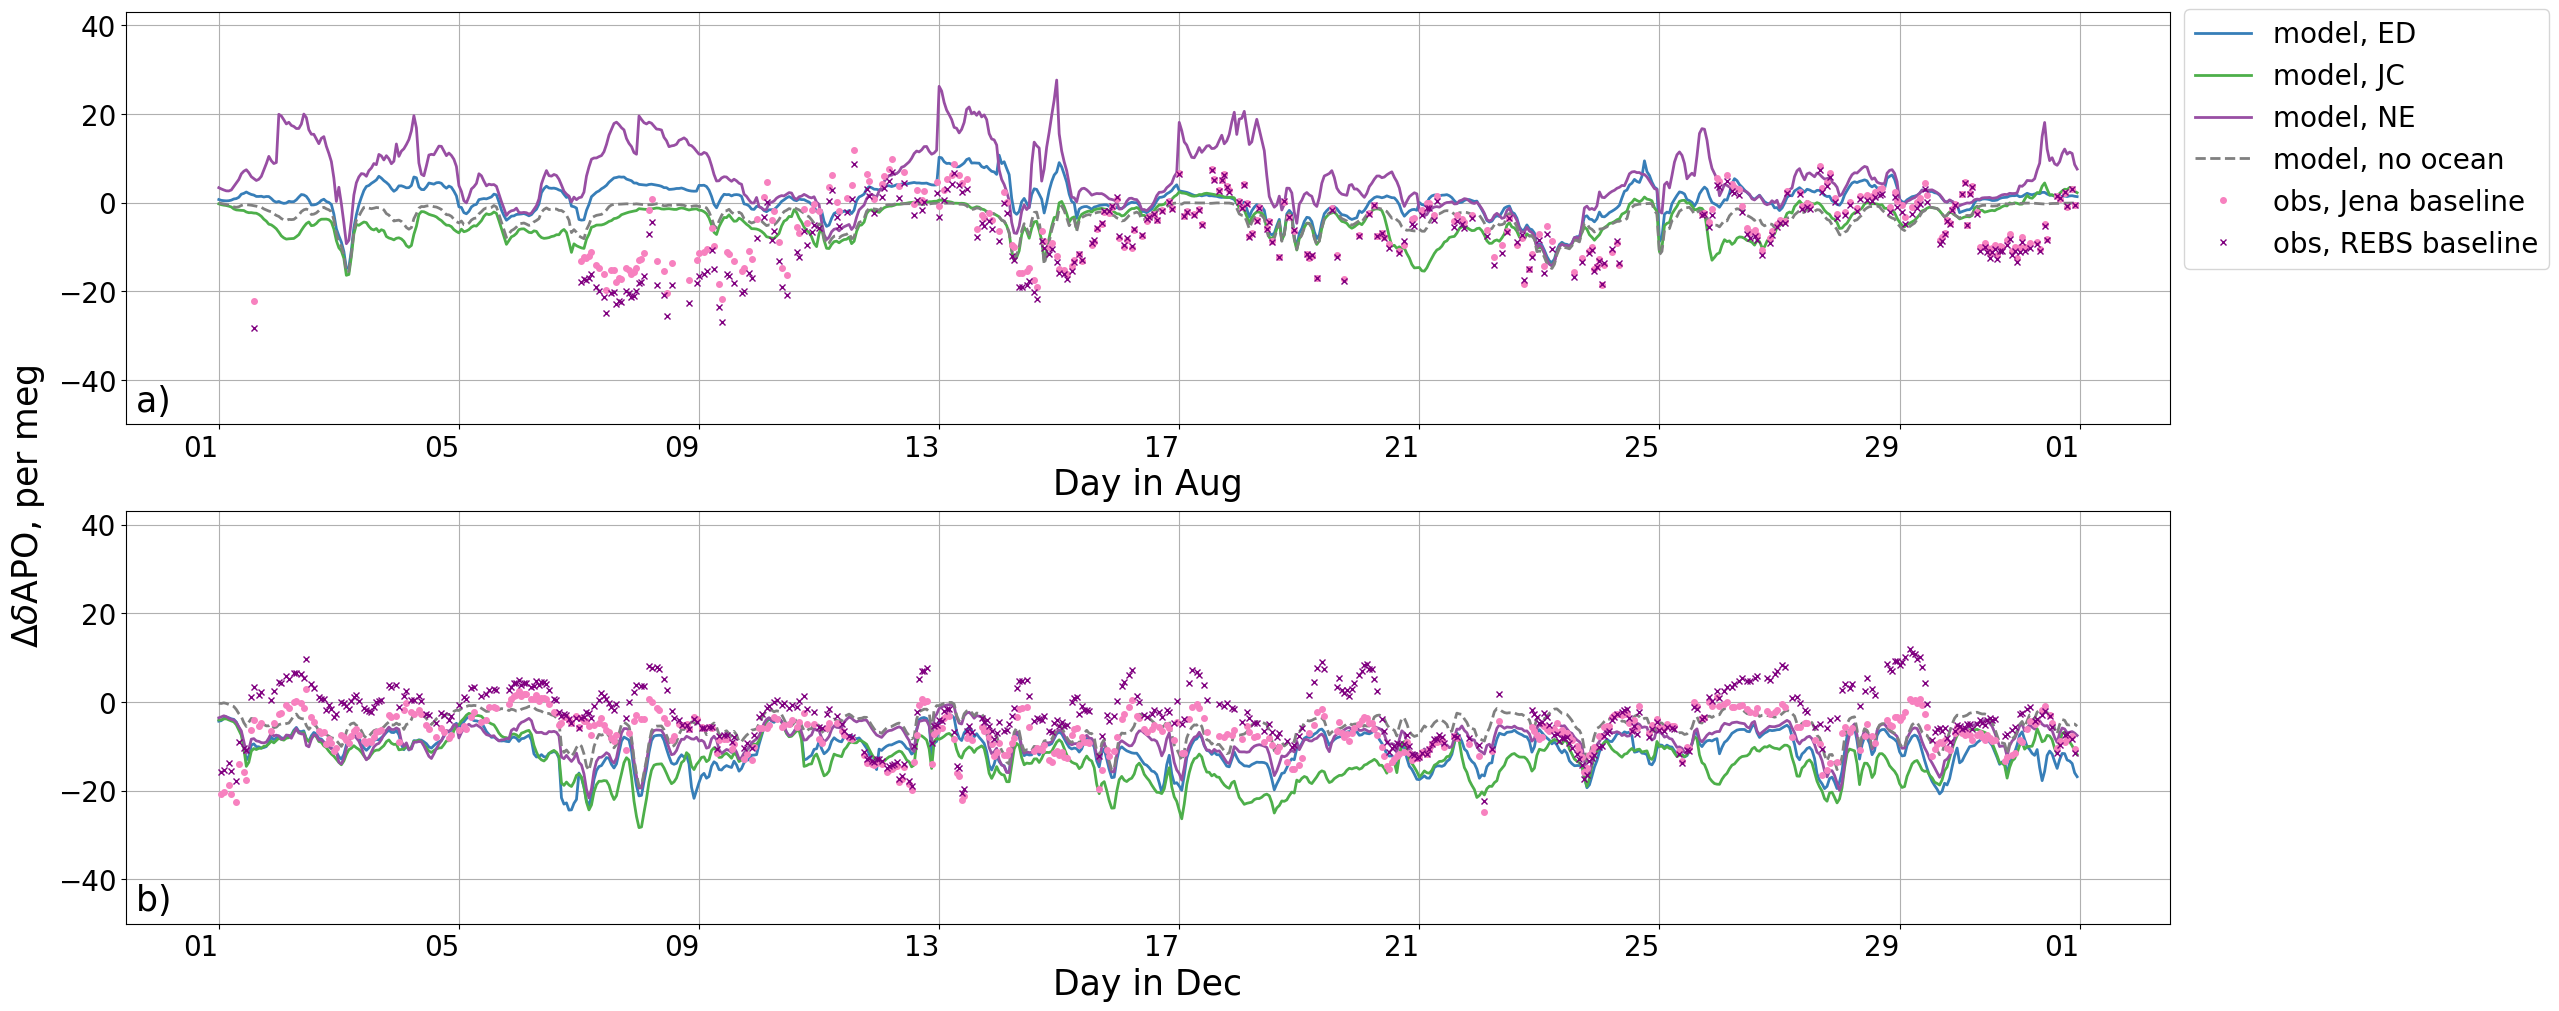

In [32]:
row_size = 3 if len(months) in [3, 4, 6] else 5 if any([len(var)>1 for var in [months, sites]]) else 5 if len(months)==2 else 8
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(25, row_size*nrows), constrained_layout=True)
axes = axes if type(axes)==np.ndarray else [axes]

ls = {sim: '--' if sim=='no ocean' else '-' for sim in apo_model[list(sites)[0]][months[0]]}
model_plots = {site: {month: {sim: apo_sim.plot(ax=axes[ss+mm*len(sites)], color=apo_plot_info.colors[sim.lower()], lw=2,
                                                ls=ls[sim], label=f'model, {apo_plot_info.model_names[sim.lower()]}')
                              for sim, apo_sim in apo_month.items()}
                      for mm, (month, apo_month) in enumerate(apo_site.items())}
               for ss, (site, apo_site) in enumerate(apo_model.items())}
label = 'observations' if not plot_both else 'obs, Jena baseline'
obs_plots = {month: {site: apo_site.plot(ax=axes[ss+mm*len(sites)], color='#f781bf', label=label, marker='o', ls='none', markersize=4)
                           if len(apo_site)>0 else None
                     for ss, (site, apo_site) in enumerate(apo_month.items())}
             for mm, (month, apo_month) in enumerate(apo_obs_bkg_sub_jena.items())}
if plot_both:
       obs_plots = {month: {site: apo_site.plot(ax=axes[ss+mm*len(sites)], color='purple', label='obs, REBS baseline', marker='x', ls='none', markersize=4)
                            if len(apo_site)>0 else None
                            for ss, (site, apo_site) in enumerate(apo_month.items())}
              for mm, (month, apo_month) in enumerate(apo_obs_bkg_sub.items())}

if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       # ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii!=len(sites)*len(months)-1]
       # text = [axes[mm*len(sites)].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm*len(sites)].transAxes, va='top', fontsize=20)
       #         for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

if nrows>1:
       letter_start = len(months)*len(sites)*(months[0]-1)/2 if supplement else 0
       letters = [chr(97 + int(letter_start+ll)) if letter_start+ll<26 else
                  chr(97 + int(letter_start+ll-26))*2
                  for ll in range(len(months)*len(sites))]
       [axes[ii].xaxis.set_ticklabels([]) for ii in [i for i in range(0, len(axes)) if (i+1)%len(sites)!=0]]
       sites_text = list(sites)*len(months) if len(sites)>1 else ['']*len(months)
       [ax.text(0.005, 0.015, f'{letters[aa]}) {sites_text[aa]}', va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]

legend = axes[0].legend(fontsize=20, bbox_to_anchor=(1., 1.04), loc='upper left') if legend_outside else \
         axes[0].legend(loc='upper right', fontsize=20)
grid = [ax.grid() for ax in axes]
xlabels = [ax.set_xlabel('') for ax in axes]
ylims = [ax.set_ylim(-50, 43) for ax in axes]
if add_xlabel:
       [axes[m*len(sites)+(len(sites)-1)].set_xlabel(f'Day in {apo_plot_info.month_names[month]}', fontsize=25)
        for m, month in enumerate(months)]
if len(axes)>1:
       ylabels = [ax.set_ylabel('') for ax in axes]
       ylabel = fig.text(-0.01, 0.5, r'$\Delta\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)
else: ylabels = axes[0].set_ylabel(r'$\Delta\delta$APO, per meg', fontsize=30)

date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
baseline_str = 'both' if plot_both else 'JC'
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                        f'DeltaAPO-{baseline_str}baseline_timeseries_{"-".join(sites)}_{date_str}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Calculate the correlations

In [18]:
rmse = {site: {month: {model.lower(): (((apo_sim - apo_obs_bkg_sub[month][site])**2).mean().values)**0.5
                       for model, apo_sim in apo_month.items() if len(apo_obs_bkg_sub[month][site])>0}
               for month, apo_month in apo_site.items()}
        for site, apo_site in apo_model.items()}

correlations = {site: {month: {model.lower(): float(xr.corr(apo_obs_bkg_sub[month][site], apo_sim))**2
                               for model, apo_sim in apo_month.items() if len(apo_obs_bkg_sub[month][site])>0}
                       for month, apo_month in apo_site.items()}
                for site, apo_site in apo_model.items()}

rmse_jena = {site: {month: {model.lower(): (((apo_sim - apo_obs_bkg_sub_jena[month][site])**2).mean().values)**0.5
                            for model, apo_sim in apo_month.items() if len(apo_obs_bkg_sub_jena[month][site])>0}
                    for month, apo_month in apo_site.items()}
             for site, apo_site in apo_model.items()}

correlations_jena = {site: {month: {model.lower(): float(xr.corr(apo_obs_bkg_sub_jena[month][site], apo_sim))**2
                                    for model, apo_sim in apo_month.items() if len(apo_obs_bkg_sub_jena[month][site])>0}
                            for month, apo_month in apo_site.items()}
                    for site, apo_site in apo_model.items()}

In [19]:
print('RMSE')
print_rmse = [[print(f'{site}, {apo_plot_info.month_names[month]} rmse:    ECCO: {rmse_month["ecco"]:.2f};   Jena: {rmse_month["jena"]:.2f};   '+
                     f'NEMO: {rmse_month["nemo"]:.2f};     no ocean: {rmse_month["no ocean"]:.2f};     average: {np.array(list(rmse_month.values())).mean():.2f}')
               for month, rmse_month in rmse_site.items() if len(rmse_month)>0]
              for site, rmse_site in rmse.items()]
print('\nCorrelation')
print_corr = [[print(f'{site}, {apo_plot_info.month_names[month]} correlation:    ECCO: {corr_month["ecco"]:.2f};   Jena: {corr_month["jena"]:.2f};   '+
                     f'NEMO: {corr_month["nemo"]:.2f};     no ocean: {corr_month["no ocean"]:.2f};     average: {np.array(list(corr_month.values())).mean():.2f}')
               for month, corr_month in corr_site.items() if len(corr_month)>0]
              for site, corr_site in correlations.items()]

RMSE
WAO, Jan rmse:    ECCO: 11.25;   Jena: 9.97;   NEMO: 7.48;     no ocean: 5.89;     average: 8.65
WAO, Feb rmse:    ECCO: 15.86;   Jena: 12.23;   NEMO: 10.92;     no ocean: 7.40;     average: 11.60
WAO, Mar rmse:    ECCO: 10.13;   Jena: 10.09;   NEMO: 9.25;     no ocean: 8.46;     average: 9.48
WAO, Apr rmse:    ECCO: 9.43;   Jena: 10.12;   NEMO: 11.75;     no ocean: 9.88;     average: 10.30
WAO, May rmse:    ECCO: 11.12;   Jena: 10.56;   NEMO: 15.79;     no ocean: 9.09;     average: 11.64
WAO, Jun rmse:    ECCO: 27.05;   Jena: 22.17;   NEMO: 31.27;     no ocean: 20.95;     average: 25.36
WAO, Jul rmse:    ECCO: 17.54;   Jena: 14.28;   NEMO: 28.20;     no ocean: 14.01;     average: 18.51
WAO, Aug rmse:    ECCO: 11.43;   Jena: 8.61;   NEMO: 16.13;     no ocean: 8.87;     average: 11.26
WAO, Sep rmse:    ECCO: 10.14;   Jena: 9.59;   NEMO: 11.78;     no ocean: 9.47;     average: 10.25
WAO, Oct rmse:    ECCO: 6.74;   Jena: 6.97;   NEMO: 6.76;     no ocean: 6.46;     average: 6.73
WAO, 

### Look at correlation for each season

In [20]:
apo_obs_bkg_sub_jena_year = {site: xr.concat([apo_obs[site] for apo_obs in apo_obs_bkg_sub_jena.values()], dim='time')
                             for site in sites}

In [21]:
seasons = {'spring': [3, 4, 5], 'summer': [6, 7, 8], 'autumn': [9, 10, 11], 'winter': [12, 1, 2]}

apo_model_season = {site: {model: {season: apo_mod.sel(time=slice(starts[season_months[0]], ends[season_months[-1]]))
                                                 if season!='winter' else
                                                 xr.concat([apo_mod.sel(time=slice(starts[season_months[1]], ends[season_months[2]])),
                                                        apo_mod.sel(time=slice(starts[season_months[0]], ends[season_months[0]]))],
                                                        dim='time')
                                          for season, season_months in seasons.items()}
                            for model, apo_mod in apo_site.items()}
                     for site, apo_site in apo_model_year.items() if len(apo_obs_year[site])>0}

for baseline, apo_sub in {'jena': apo_obs_bkg_sub_jena_year, 'REBS': apo_obs_bkg_sub_yr}.items():
       print(baseline)
       apo_obs_season = {site: {season: apo_site.sel(time=slice(starts[season_months[0]], ends[season_months[-1]]))
                                        if season!='winter' else
                                        xr.concat([apo_site.sel(time=slice(starts[season_months[1]], ends[season_months[2]])),
                                                   apo_site.sel(time=slice(starts[season_months[0]], ends[season_months[0]]))],
                                                   dim='time')
                                for season, season_months in seasons.items()}
                         for site, apo_site in apo_sub.items() if len(apo_site)>0}

       rmse_season = {site: {model: {season: (((apo_season - apo_obs_season[site][season])**2).mean().values)**0.5
                                    for season, apo_season in apo_sim.items()}
                             for model, apo_sim in apo_site.items()}
                      for site, apo_site in apo_model_season.items()}

       correlations_season = {site: {model: {season: float(xr.corr(apo_obs_season[site][season], apo_season)**2)
                                          for season, apo_season in apo_sim.items()}
                                   for model, apo_sim in apo_site.items()}
                            for site, apo_site in apo_model_season.items()}
       
       print('RMSE')
       print_rmse = [[print(f'{site}, {sim} rmse:    spring: {rmse_sim["spring"]:.2f};   ' +
                            f'summer: {rmse_sim["summer"]:.2f};   autumn: {rmse_sim["autumn"]:.2f};   winter: {rmse_sim["winter"]:.2f}')
                      for sim, rmse_sim in rmse_site.items()]
                     for site, rmse_site in rmse_season.items()]
       print('\nR^2 Correlation')
       print_corr = [[print(f'{site}, {sim} correlation:    spring: {corr_sim["spring"]:.2f};   ' +
                            f'summer {corr_sim["summer"]:.2f};   autumn: {corr_sim["autumn"]:.2f};   winter: {corr_sim["winter"]:.2f}')
                      for sim, corr_sim in corr_site.items()]
                     for site, corr_site in correlations_season.items()]
       print('\n')

jena
RMSE
WAO, ecco rmse:    spring: 12.50;   summer: 11.05;   autumn: 7.99;   winter: 9.92
WAO, jena rmse:    spring: 11.88;   summer: 10.01;   autumn: 9.26;   winter: 9.17
WAO, nemo rmse:    spring: 14.90;   summer: 17.55;   autumn: 8.25;   winter: 7.16
WAO, no ocean rmse:    spring: 10.98;   summer: 9.97;   autumn: 8.34;   winter: 6.04

R^2 Correlation
WAO, ecco correlation:    spring: 0.01;   summer 0.09;   autumn: 0.37;   winter: 0.06
WAO, jena correlation:    spring: 0.02;   summer 0.02;   autumn: 0.30;   winter: 0.14
WAO, nemo correlation:    spring: 0.01;   summer 0.03;   autumn: 0.26;   winter: 0.13
WAO, no ocean correlation:    spring: 0.05;   summer 0.01;   autumn: 0.26;   winter: 0.23


REBS
RMSE
WAO, ecco rmse:    spring: 10.49;   summer: 16.14;   autumn: 8.50;   winter: 11.21
WAO, jena rmse:    spring: 10.33;   summer: 12.93;   autumn: 9.12;   winter: 11.54
WAO, nemo rmse:    spring: 13.33;   summer: 23.55;   autumn: 9.00;   winter: 8.42
WAO, no ocean rmse:    spring: 9.0

Saving to /user/work/vf20487/Figures/APO_timeseries/DeltaAPO_correlations_WAO_2015.png


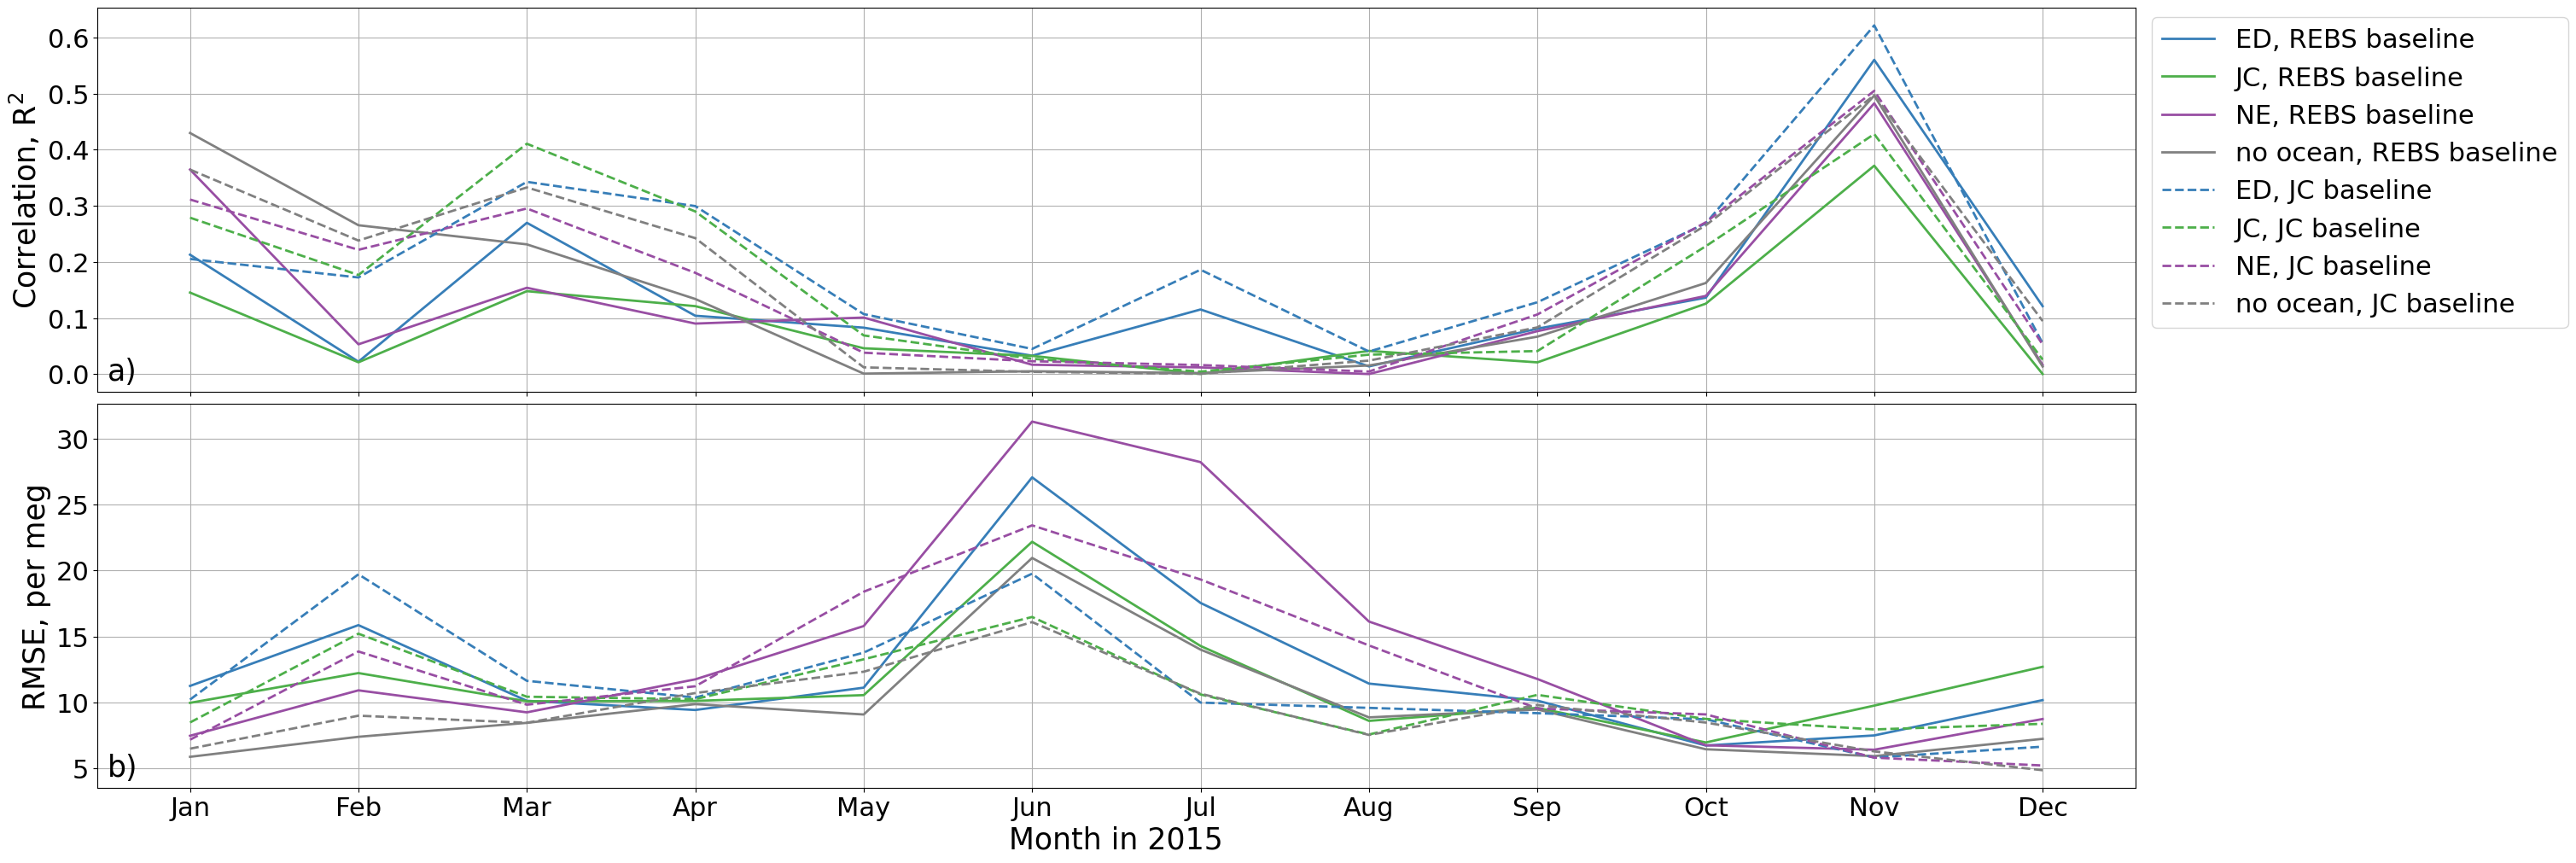

In [22]:
if len(months)>=12:
    sites_plot = ['WAO']
    sites_plot = [site for site in sites_plot if site in sites]

    fig, axes = plt.subplots(nrows=2*len(sites_plot), ncols=1, figsize=(25, 10*len(sites_plot)), sharex=True, constrained_layout=True)

    corr_plot = [[axes[ss].plot(apo_plot_info.month_names.values(), [rr[sim] for rr in correlations[site].values()],
                                color=apo_plot_info.colors[sim], label=f'{apo_plot_info.model_names[sim]}, REBS baseline', ls='-', lw=2)
                  for sim in apo_model['WAO'][months[0]].keys() if sim!='ff'] for ss, site in enumerate(sites_plot)]
    rmse_plot = [[axes[len(sites_plot)+ss].plot(apo_plot_info.month_names.values(), [rr[sim] for rr in rmse[site].values()],
                                                color=apo_plot_info.colors[sim], ls='-', lw=2)
                     for sim in apo_model['WAO'][months[0]].keys() if sim!='ff'] for ss, site in enumerate(sites_plot)]

    corr_plot_jena = [[axes[ss].plot(apo_plot_info.month_names.values(), [rr[sim] for rr in correlations_jena[site].values()],
                                     color=apo_plot_info.colors[sim], label=f'{apo_plot_info.model_names[sim]}, JC baseline', ls='--', lw=2)
                      for sim in apo_model['WAO'][months[0]].keys() if sim!='ff'] for ss, site in enumerate(sites_plot)]
    rmse_plot_jena = [[axes[len(sites_plot)+ss].plot(apo_plot_info.month_names.values(), [rr[sim] for rr in rmse_jena[site].values()],
                                                     color=apo_plot_info.colors[sim], ls='--', lw=2)
                      for sim in apo_model['WAO'][months[0]].keys() if sim!='ff'] for ss, site in enumerate(sites_plot)]
        

    ticks = [ax.tick_params(labelsize=22) for ax in axes]
    legend = fig.legend(bbox_to_anchor=(1, 1), fontsize=22, loc='upper left')
    grid = [ax.grid() for ax in axes]
    xlabels = [ax.set_xlabel('') for ax in axes]
    xlabel = axes[1].set_xlabel(f'Month in {year}', fontsize=25)
    ylabels = [axes[ll].set_ylabel(label, fontsize=25)
               for ll, label in enumerate([r'Correlation, R$^2$', 'RMSE, per meg'])]
    ax_labels = [ax.text(0.005, 0.015, f'{chr(97+aa)})', va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]

    date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
    filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                            f'DeltaAPO_correlations_{"-".join(sites_plot)}_{date_str}.png')
    
    print(f'Saving to {filename}')
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

In [ ]:
seasons = {'spring': [3, 4, 5], 'summer': [6, 7, 8], 'autumn': [9, 10, 11], 'winter': [12, 1, 2]}

apo_model_season = {site: {model: {season: apo_mod.sel(time=slice(starts[season_months[0]], ends[season_months[-1]]))
                                           if season!='winter' else
                                           xr.concat([apo_mod.sel(time=slice(starts[season_months[1]], ends[season_months[2]])),
                                                      apo_mod.sel(time=slice(starts[season_months[0]], ends[season_months[0]]))],
                                                     dim='time')
                                   for season, season_months in seasons.items()}
                           for model, apo_mod in apo_site.items()}
                    for site, apo_site in apo_model_yr_rebs.items() if len(apo_obs_year[site])>0}
apo_obs_season = {site: {season: apo_site[0].mf.sel(time=slice(starts[season_months[0]], ends[season_months[-1]]))
                                 if season!='winter' else
                                 xr.concat([apo_site[0].mf.sel(time=slice(starts[season_months[1]], ends[season_months[2]])),
                                            apo_site[0].mf.sel(time=slice(starts[season_months[0]], ends[season_months[0]]))],
                                           dim='time')
                         for season, season_months in seasons.items()}
                  for site, apo_site in apo_obs_year.items() if len(apo_site)>0}

rmse_season = {site: {model: {season: (((apo_season - apo_obs_season[site][season])**2).mean().values)**0.5
                              for season, apo_season in apo_sim.items()}
                      for model, apo_sim in apo_site.items()}
               for site, apo_site in apo_model_season.items()}

correlations_season = {site: {model: {season: float(xr.corr(apo_obs_season[site][season], apo_season)**2)
                                      for season, apo_season in apo_sim.items()}
                              for model, apo_sim in apo_site.items()}
                       for site, apo_site in apo_model_season.items()}

## Add REBS baseline to model

In [7]:
obs_baseline_yr.set_index('date', inplace=True)
obs_baseline_yr = obs_baseline_yr['Stiff baseline - small gaps interpolated']

In [8]:
apo_model_yr_rebs = {site: {sim: apo_sim + obs_baseline_yr
                            for sim, apo_sim in apo_site.items()}
                     for site, apo_site in apo_model_year.items()}
apo_model_rebs = {site: {month: {sim: apo_sim.sel(time=slice(start, ends[month])).dropna(dim='time')
                                 for sim, apo_sim in apo_site.items()}
                         for month, start in starts.items()}
                  for site, apo_site in apo_model_yr_rebs.items()}


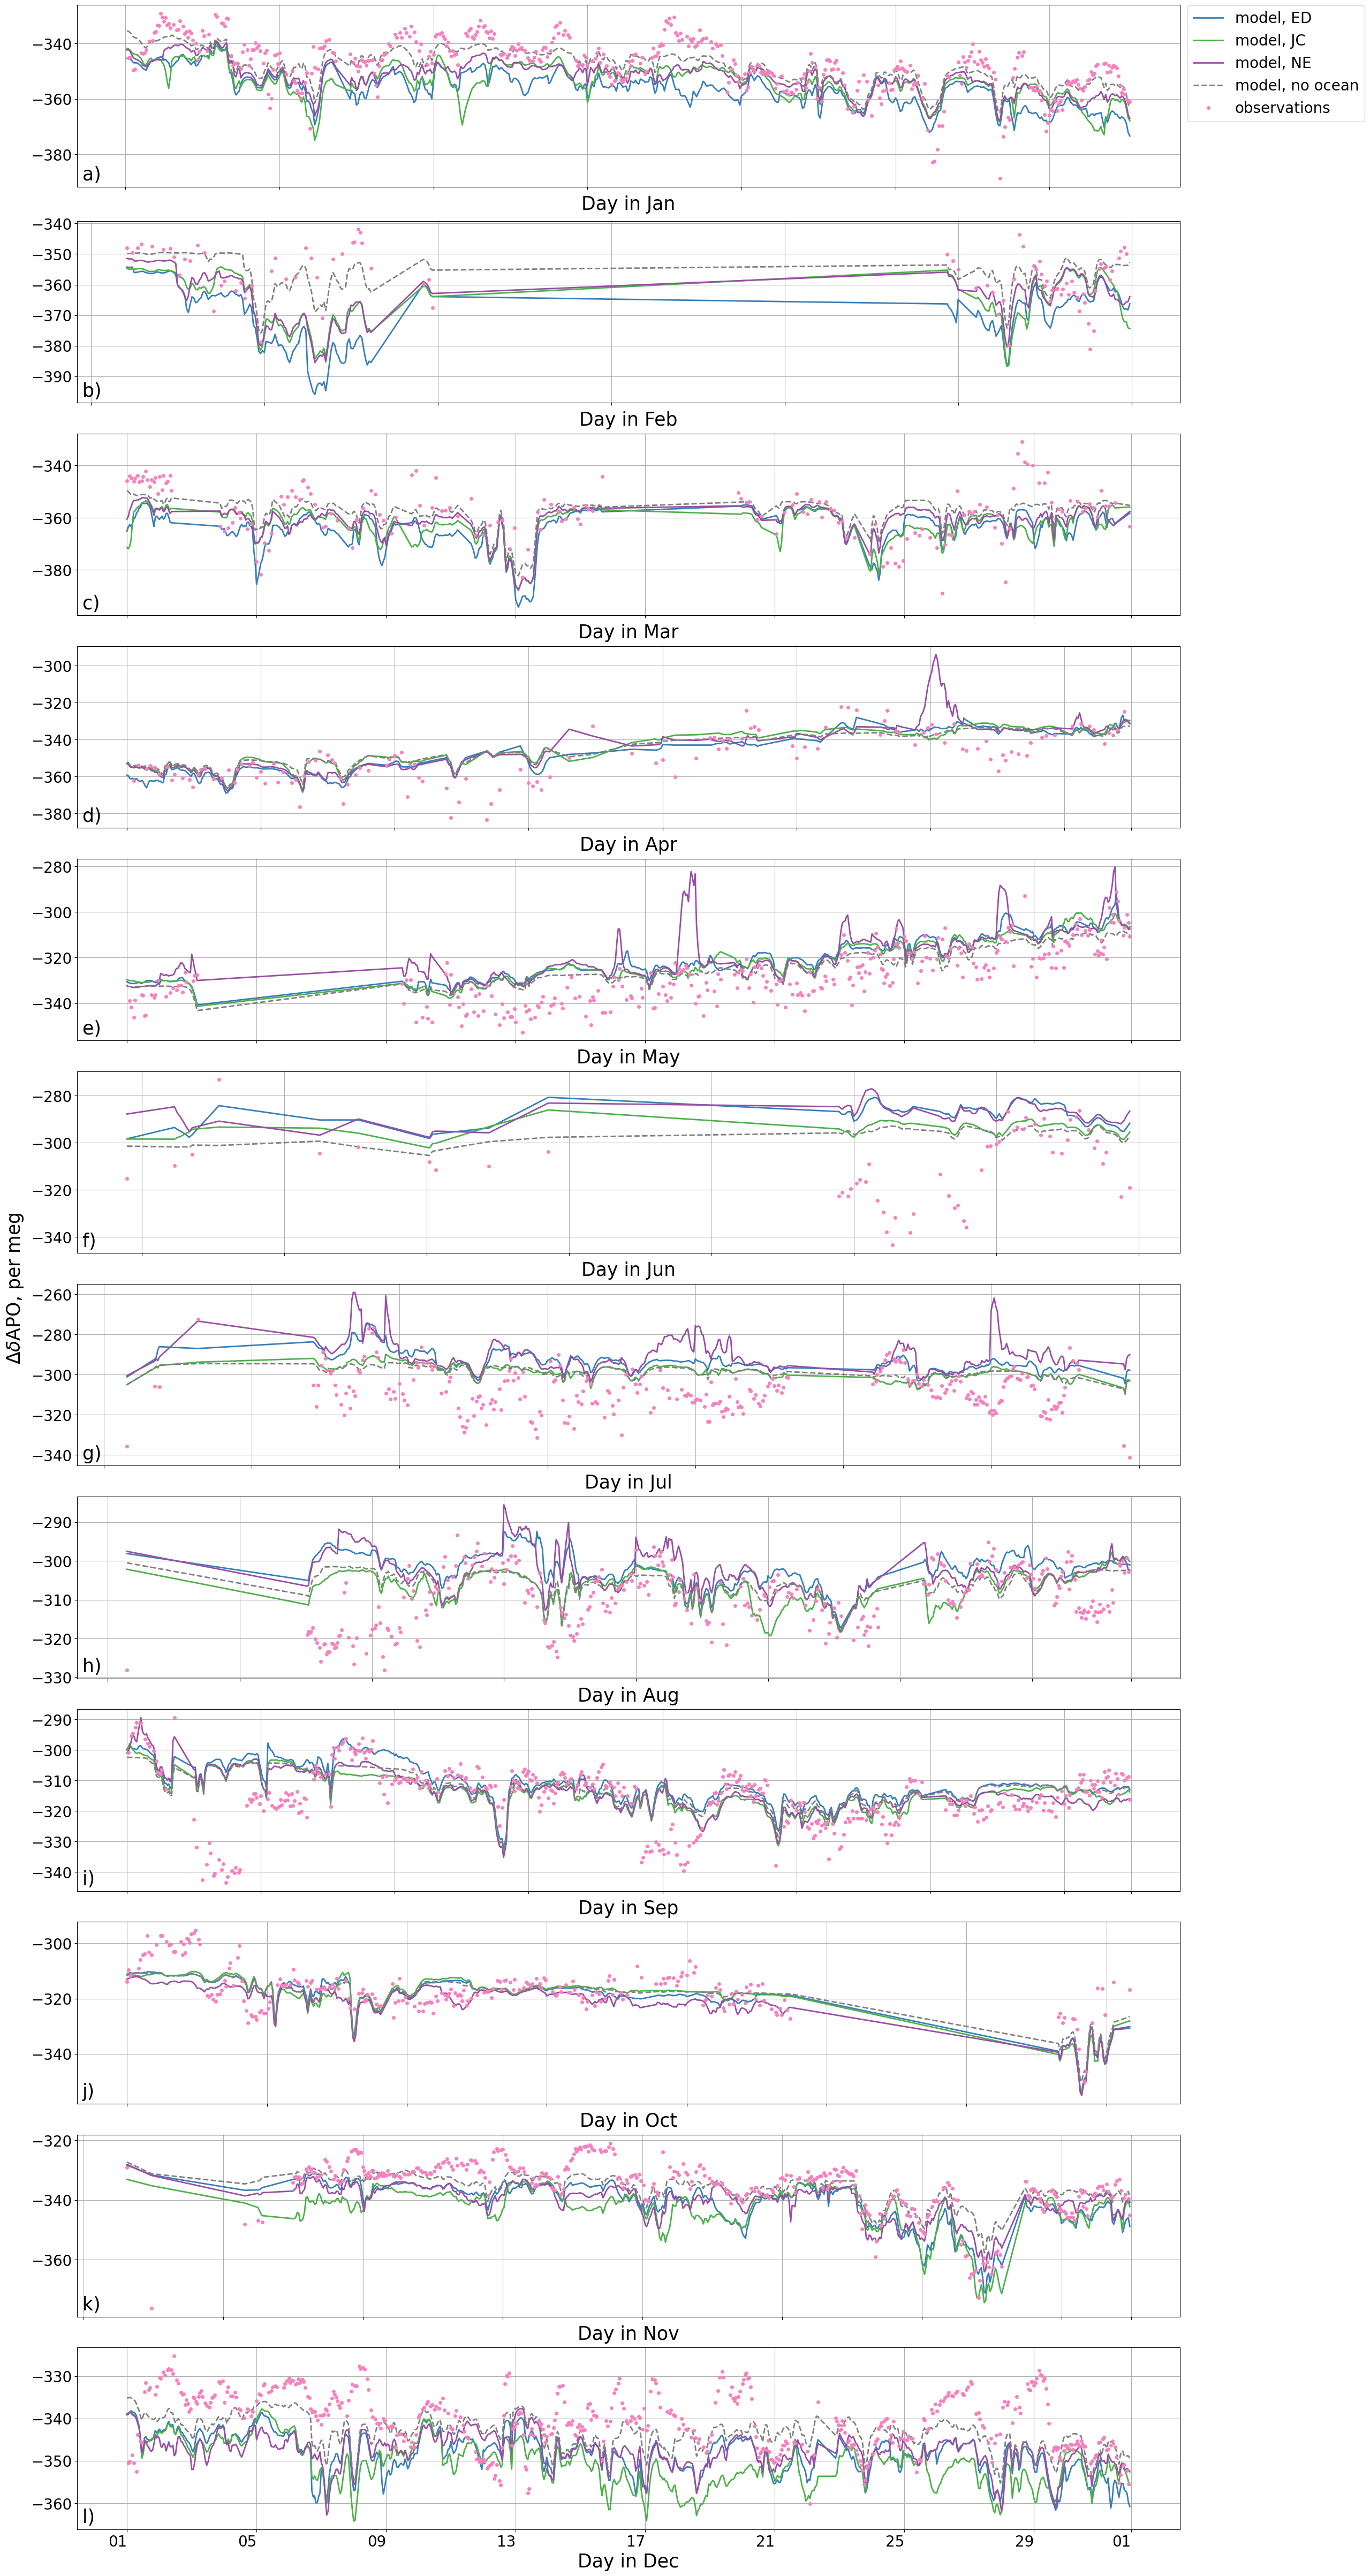

In [9]:
row_size = 3 if len(months) in [3, 4, 6] else 4 if any([len(var)>1 for var in [months, sites]]) else 5 if len(months)==2 else 8
fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(25, row_size*nrows), constrained_layout=True)
axes = axes if type(axes)==np.ndarray else [axes]

ls = {sim: '--' if sim=='no ocean' else '-' for sim in apo_model[list(sites)[0]][months[0]]}
model_plots = {site: {month: {sim: apo_sim.plot(ax=axes[ss+mm*len(sites)], color=apo_plot_info.colors[sim.lower()], lw=2,
                                                ls=ls[sim], label=f'model, {apo_plot_info.model_names[sim.lower()]}')
                              for sim, apo_sim in apo_month.items()}
                      for mm, (month, apo_month) in enumerate(apo_site.items())}
               for ss, (site, apo_site) in enumerate(apo_model_rebs.items())}
label = 'observations'
obs_plots = {month: {site: apo_site[0].mf.plot(ax=axes[ss+mm*len(sites)], color='#f781bf', label=label, marker='o', ls='none', markersize=4)
                           if len(apo_site)>0 else None
                     for ss, (site, apo_site) in enumerate(apo_month.items())}
             for mm, (month, apo_month) in enumerate(apo_obs.items())}

if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       ticks = [axes[ii].xaxis.set_ticklabels([]) for ii in range(len(axes)) if ii!=len(sites)*len(months)-1]
       # text = [axes[mm*len(sites)].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm*len(sites)].transAxes, va='top', fontsize=20)
       #         for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

if nrows>1:
       letter_start = 0 #len(months)*len(sites)*(months[0]-1)/2 if supplement else 0
       letters = [chr(97 + int(letter_start+ll)) if letter_start+ll<26 else
                  chr(97 + int(letter_start+ll-26))*2
                  for ll in range(len(months)*len(sites))]
       [axes[ii].xaxis.set_ticklabels([]) for ii in [i for i in range(0, len(axes)) if (i+1)%len(sites)!=0]]
       sites_text = list(sites)*len(months) if len(sites)>1 else ['']*len(months)
       [ax.text(0.005, 0.015, f'{letters[aa]}) {sites_text[aa]}', va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]

legend = axes[0].legend(fontsize=20, bbox_to_anchor=(1., 1.04), loc='upper left')
grid = [ax.grid() for ax in axes]
xlabels = [ax.set_xlabel('') for ax in axes]
# ylims = [ax.set_ylim(-50, 43) for ax in axes]
[axes[m*len(sites)+(len(sites)-1)].set_xlabel(f'Day in {apo_plot_info.month_names[month]}', fontsize=25)
 for m, month in enumerate(months)]
if len(axes)>1:
       ylabels = [ax.set_ylabel('') for ax in axes]
       ylabel = fig.text(-0.01, 0.5, r'$\Delta\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25)
else: ylabels = axes[0].set_ylabel(r'$\Delta\delta$APO, per meg', fontsize=30)

# date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
# baseline_str = 'both' if plot_both else 'JC'
# filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
#                         f'DeltaAPO-{baseline_str}baseline_timeseries_{"-".join(sites)}_{date_str}.png')
# print(f'Saving to {filename}')
# fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

In [12]:
rmse_rebs = {site: {month: {model.lower(): (((apo_sim - apo_obs[month][site][0].mf)**2).mean().values)**0.5
                            for model, apo_sim in apo_month.items() if len(apo_obs[month][site][0].mf)>0}
                    for month, apo_month in apo_site.items()}
             for site, apo_site in apo_model_rebs.items()}

correlations_rebs = {site: {month: {model.lower(): float(xr.corr(apo_obs[month][site][0].mf, apo_sim))**2
                                    for model, apo_sim in apo_month.items() if len(apo_obs[month][site][0].mf)>0}
                            for month, apo_month in apo_site.items()}
                     for site, apo_site in apo_model_rebs.items()}

if len(months)>=12:
    sites_plot = ['WAO']
    sites_plot = [site for site in sites_plot if site in sites]

    fig, axes = plt.subplots(nrows=2*len(sites_plot), ncols=1, figsize=(25, 10*len(sites_plot)), sharex=True, constrained_layout=True)

    corr_plot = [[axes[ss].plot(apo_plot_info.month_names.values(), [rr[sim] for rr in correlations_rebs[site].values()],
                                color=apo_plot_info.colors[sim], label=f'{apo_plot_info.model_names[sim]}, REBS baseline', ls='-', lw=2)
                  for sim in apo_model['WAO'][months[0]].keys() if sim!='ff'] for ss, site in enumerate(sites_plot)]
    rmse_plot = [[axes[len(sites_plot)+ss].plot(apo_plot_info.month_names.values(), [rr[sim] for rr in rmse_rebs[site].values()],
                                                color=apo_plot_info.colors[sim], ls='-', lw=2)
                     for sim in apo_model_rebs['WAO'][months[0]].keys() if sim!='ff'] for ss, site in enumerate(sites_plot)]
        

    ticks = [ax.tick_params(labelsize=22) for ax in axes]
    legend = fig.legend(bbox_to_anchor=(1, 1), fontsize=22, loc='upper left')
    grid = [ax.grid() for ax in axes]
    xlabels = [ax.set_xlabel('') for ax in axes]
    xlabel = axes[1].set_xlabel(f'Month in {year}', fontsize=25)
    ylabels = [axes[ll].set_ylabel(label, fontsize=25)
               for ll, label in enumerate([r'Correlation, R$^2$', 'RMSE, per meg'])]
    ax_labels = [ax.text(0.005, 0.015, f'{chr(97+aa)})', va='bottom', transform=ax.transAxes, fontsize=25) for aa, ax in enumerate(axes)]

    date_str = "-".join([f'{year}{str(mm).zfill(2)}' for mm in months]) if date_str is None else date_str
    filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'APO_timeseries',
                            f'APO-REBS_correlations_{"-".join(sites_plot)}_{date_str}.png')
    
    print(f'Saving to {filename}')
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

NameError: name 'apo_model_rebs' is not defined

In [13]:
seasons = {'spring': [3, 4, 5], 'summer': [6, 7, 8], 'autumn': [9, 10, 11], 'winter': [12, 1, 2]}

apo_model_season = {site: {model: {season: apo_mod.sel(time=slice(starts[season_months[0]], ends[season_months[-1]]))
                                           if season!='winter' else
                                           xr.concat([apo_mod.sel(time=slice(starts[season_months[1]], ends[season_months[2]])),
                                                      apo_mod.sel(time=slice(starts[season_months[0]], ends[season_months[0]]))],
                                                     dim='time')
                                   for season, season_months in seasons.items()}
                           for model, apo_mod in apo_site.items()}
                    for site, apo_site in apo_model_yr_rebs.items() if len(apo_obs_year[site])>0}
apo_obs_season = {site: {season: apo_site[0].mf.sel(time=slice(starts[season_months[0]], ends[season_months[-1]]))
                                 if season!='winter' else
                                 xr.concat([apo_site[0].mf.sel(time=slice(starts[season_months[1]], ends[season_months[2]])),
                                            apo_site[0].mf.sel(time=slice(starts[season_months[0]], ends[season_months[0]]))],
                                           dim='time')
                         for season, season_months in seasons.items()}
                  for site, apo_site in apo_obs_year.items() if len(apo_site)>0}

rmse_season = {site: {model: {season: (((apo_season - apo_obs_season[site][season])**2).mean().values)**0.5
                              for season, apo_season in apo_sim.items()}
                      for model, apo_sim in apo_site.items()}
               for site, apo_site in apo_model_season.items()}

correlations_season = {site: {model: {season: float(xr.corr(apo_obs_season[site][season], apo_season)**2)
                                      for season, apo_season in apo_sim.items()}
                              for model, apo_sim in apo_site.items()}
                       for site, apo_site in apo_model_season.items()}

In [15]:
print('RMSE, NEMO')
print_rmse = [print(f'{site}, rmse:    spring: {rmse_site["nemo"]["spring"]:.2f};   ' +
                     f'summer: {rmse_site["nemo"]["summer"]:.2f};   autumn: {rmse_site["nemo"]["autumn"]:.2f};   winter: {rmse_site["nemo"]["winter"]:.2f}')
              for site, rmse_site in rmse_season.items()]
print('\nR^2 Correlation, NEMO')
print_corr = [print(f'{site}, correlation:    spring: {corr_site["nemo"]["spring"]:.2f};   ' +
                     f'summer {corr_site["nemo"]["summer"]:.2f};   autumn: {corr_site["nemo"]["autumn"]:.2f};   winter: {corr_site["nemo"]["winter"]:.2f}')
              for site, corr_site in correlations_season.items()]

RMSE, NEMO
WAO, rmse:    spring: 11.87;   summer: 18.34;   autumn: 8.42;   winter: 9.37

R^2 Correlation, NEMO
WAO, correlation:    spring: 0.75;   summer 0.01;   autumn: 0.65;   winter: 0.43
